#Statistics 72556 Homework #3
Written by Raafi Rahman in Google Colab

##Chapter 15 Problem 10

Download the Bach chorales dataset (https://homl.info/bach) and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent  or convolutional —that can predict the next time step (4 notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on.

####Libraries and helper functions

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split

#try:
#    # %tensorflow_version only exists in Colab.
#    %tensorflow_version 2.x
#    IS_COLAB = True
#except Exception:
#    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import random
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9601066076021814339
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12797937336738230023
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

#### Import Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
folder = 'gdrive/My Drive/Colab Notebooks/Advanced Machine Learning/Datasets/jsb_chorales'

train = []
test = []
valid = []

for split in os.listdir(folder):
  for chorale in os.listdir(os.path.join(folder, split)):

    choralePath = os.path.join(folder, split, chorale)
    df = pd.DataFrame(pd.read_csv(choralePath)).values.astype(np.int32).tolist()
    
    if split == "train":
      train.append(df[:32])
    elif split == "test":
      test.append(df[:32])
    else:
      valid.append(df[:32])

In [ ]:
train[0]

[[64, 60, 57, 57],
 [64, 60, 57, 57],
 [65, 60, 57, 57],
 [65, 60, 57, 57],
 [67, 60, 55, 52],
 [67, 60, 55, 52],
 [67, 60, 55, 52],
 [67, 60, 55, 52],
 [69, 60, 53, 53],
 [69, 60, 53, 53],
 [69, 60, 53, 53],
 [69, 60, 53, 53],
 [67, 60, 52, 48],
 [67, 60, 52, 48],
 [67, 60, 53, 50],
 [67, 60, 53, 50],
 [72, 60, 55, 52],
 [72, 60, 55, 52],
 [72, 62, 57, 53],
 [72, 62, 57, 53],
 [72, 64, 55, 55],
 [72, 64, 55, 55],
 [72, 64, 55, 55],
 [72, 64, 55, 55],
 [71, 62, 55, 43],
 [71, 62, 55, 43],
 [71, 62, 55, 43],
 [71, 62, 55, 43],
 [72, 64, 55, 48],
 [72, 64, 55, 48],
 [72, 64, 55, 48],
 [72, 64, 55, 48]]

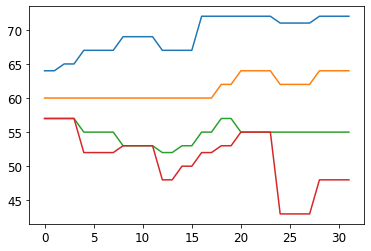

In [ ]:
plt.plot(train[0])

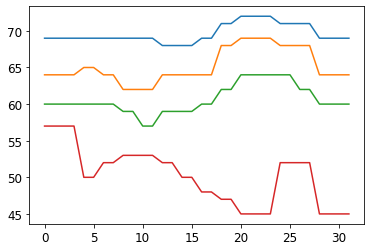

In [ ]:
plt.plot(test[0])

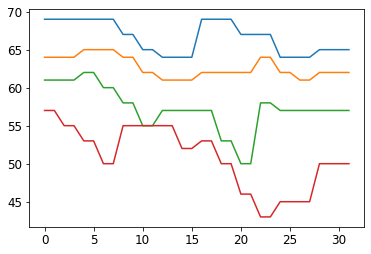

In [ ]:
plt.plot(valid[0])

####CNN Model

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=2, padding="SAME", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="SAME", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="SAME", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=2, padding="SAME", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation="softmax")
])

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train, train, epochs=20, validation_data=(valid, valid))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


InvalidArgumentError: ignored

####Generate Music

In [ ]:
def show_reconstructions(model, images=valid, n=5):
    reconstructions = model.predict(images[:n])
    fig = plt.figure(figsize=(n * 1.5, 3))
    for image_index in range(n):
        plt.subplot(2, n, 1 + image_index)
        plt.plot(images[image_index])
        plt.subplot(2, n, 1 + n + image_index)
        plt.plot(reconstructions[image_index])